## Implement and test explicit Runge Kutta methods
The input to the Runge-Kutta solver is:
-  the right hand side function of the ODE
-  initial values
-  the coefficients of the Butcher tableau (assuming a strict lower left triangular matrix for the a-coefficients)
-  the time-step h 

The output are the state variables at the discrete times $jh$. Solve the ODEs from the previous examples, using explicit Euler, the improved Euler, and the classical RK4 methods.  Find a stable time-step by trial-and-error. Plot the solutions.

## Runge-Kutta methods

Numerical methods based on integral equation

$ y(t) = y_n + \int_{t_n}^t f(s, y(s)) ds $

fot $ t \in [t_n, t_{n+1}] $

--> approximate the integral with a quadrature

example: mid-point rule:
$ \int_{a}^b f(s) ds \approx h\cdot f(\frac{a+b}{2}) $

$ y_{n+1} = y_n + h \cdot f(t_{n+1/2}, y_{n+1/2}) $

Problem: $y_{n+1/2}$ is unknown

--> also approximate needed intermediate steps for the quadrature with numerical methods

$ y_{n+1} = y_n + \int_{t_n}^{t_{n+1}} f(s, y(s)) ds $

$ \approx y_n + h \sum_{j=1}^s b_j f(t_n + c_jh, y(t_n + c_jh)) $

$b_j$ are the integration weights and $c_j$ the integration points on the unit interval from the quadrature.

$y_{n, j} := y(t_n + c_jh)$ ... the j-th intermediate step in the interval $ [t_n, t_{n+1}) $

Integral equation for intermediate steps $y_{n, j}$:

$ y_{n, j} = y_n + \int_{t_n}^{t_n+c_jh} f(s, y(s)) ds $

$ \approx y_n + h \sum_{l=1}^s a_{j, l} f(t_n + c_lh, y(t_n + c_lh)) $

$a_{j, l}$ are the integration weights of the quadratures for the intermediate steps, which use the same integration points!

### Runge-Kutta equations

$ y_{n, j} = y_n + h \sum_{l=1}^s a_{j, l} f(t_n + c_lh, y(t_n + c_lh)) $

$ y_{n+1} = y_n + h \sum_{j=1}^s b_j f(t_n + c_jh, y(t_n + c_jh)) $

many possible quadrature rules for both the intermediate steps and the whole update step. --> Defined by coefficients $a_{j, l}, b_j, c_j$. Often in Butcher Tableau:

$$ \left(\begin{array}{c|ccc} 
c_1& a_{1,1} & \dots & a_{1,s} \\
\vdots & \vdots & & \vdots \\
c_s& a_{s,1} & \dots & a_{s,s}\\
\hline 
& b_{1} & \dots & b_{s}
\end{array}\right) $$

In [201]:
import numpy as np
import matplotlib.pyplot as plt


def explicit_runge_kutta(rhs, y0, t, a, b, c, h, args):
    s = len(b)

    t0, t_end = t
    num_steps = int(np.ceil((t_end - t0) / h))
    t_list = np.arange(t0, t_end, h)

    y_out = np.zeros((num_steps, len(y0)))
    y_out[0, :] = y0

    for step_idx, t_n in enumerate(t_list[:-1]):
        #  print("step: ", step_idx)
        y_n = y_out[step_idx, :]

        y_nj = np.zeros((s, len(y0)))
        f_y_nj = np.zeros((s, len(y0)))

        t_nl = t_n + c * h

        for j in range(s):
            if j == 0:
                f_y_nj[j, :] = rhs(t_nl[j], y_n, *args)
            else:
                f_y_nj[j, :] = rhs(t_nl[j], y_nj[j-1, :], *args)

            y_nj[j, :] = y_n + h * np.sum(a[j, :j+1][np.newaxis].T * f_y_nj[:j+1, :], axis=0)

        f_y_nj = np.roll(f_y_nj, -1, axis=0)
        f_y_nj[-1, :] = rhs(t_nl[-1], y_nj[-1, :], *args)

        y_out[step_idx+1, :] = y_n + h * np.sum(b[np.newaxis].T * f_y_nj, axis=0)

    return y_out, t_list

In [202]:
# Explicit Euler
# 1st order accurate
a_ee = np.array([[0]])
b_ee = np.array([1])
c_ee = np.array([0])

# The classical RK4 method
a_rk4 = np.diag([1/2, 1/2, 1], -1)
b_rk4 = np.array([1/6, 1/3, 1/3, 1/6])
c_rk4 = np.array([0, 1/2, 1/2, 1])

# Explicit mid-point aka improved Euler
a_mp = np.diag([1/2], -1)
b_mp = np.array([0, 1])
c_mp = np.array([0, 1/2])

In [203]:
def rhs_rc_circuit(t, u_c12, R1, R2, C1, C2):
    uc1, uc2 = u_c12
    us = np.sin(t)
    
    return [(-R1-R2)/(C1*R1*R2)*uc1 + 1/(R2*C1)*uc2 + us/(R1*C1), uc1/(R2*C2) - uc2/(R2*C2)]


def rhs_double_pendulum(t, state_vec, m1, m2, k1, k2, l01, l02):
    x1, y1, x2, y2, p1x, p1y, p2x, p2y = state_vec
    g = 9.81
    
    dq1_dt = p1x/m1
    dq2_dt = p1y/m1
    dq3_dt = p2x/m2
    dq4_dt = p2y/m2
    
    s1 = np.sqrt(x1**2 + y1**2)
    s2 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    dp1_dt = -k1*x1 * (s1 - l01)/s1 + k2*(x2-x1)*(s2-l02)/s2
    dp2_dt = -k1*y1 * (s1 - l01)/s1 + k2*(y2-y1)*(s2-l02)/s2 - m1 * g
    dp3_dt = -k2*(x2-x1)*(s2 - l02)/s2
    dp4_dt = -k2*(y2-y1)*(s2 - l02)/s2 - m2 * g
    
    return [dq1_dt, dq2_dt, dq3_dt, dq4_dt, dp1_dt, dp2_dt, dp3_dt, dp4_dt]

In [224]:
from scipy.integrate import solve_ivp

sol = solve_ivp(rhs_rc_circuit, [0, 5*2*np.pi], [0, 0], dense_output=True, 
                args=(1, 1, 0.47, 2.2e-3), atol=1e-5, rtol=1e-8, method="Radau")
t = np.linspace(0, 5*2*np.pi, 1000)
z = sol.sol(t)

<ipython-input-203-c1136481cea9>:5: RuntimeWarning: overflow encountered in double_scalars
  return [(-R1-R2)/(C1*R1*R2)*uc1 + 1/(R2*C1)*uc2 + us/(R1*C1), uc1/(R2*C2) - uc2/(R2*C2)]
<ipython-input-201-8df6c78dda42>:30: RuntimeWarning: invalid value encountered in multiply
  y_nj[j, :] = y_n + h * np.sum(a[j, :j+1][np.newaxis].T * f_y_nj[:j+1, :], axis=0)
<ipython-input-203-c1136481cea9>:5: RuntimeWarning: overflow encountered in double_scalars
  return [(-R1-R2)/(C1*R1*R2)*uc1 + 1/(R2*C1)*uc2 + us/(R1*C1), uc1/(R2*C2) - uc2/(R2*C2)]
<ipython-input-201-8df6c78dda42>:30: RuntimeWarning: invalid value encountered in multiply
  y_nj[j, :] = y_n + h * np.sum(a[j, :j+1][np.newaxis].T * f_y_nj[:j+1, :], axis=0)


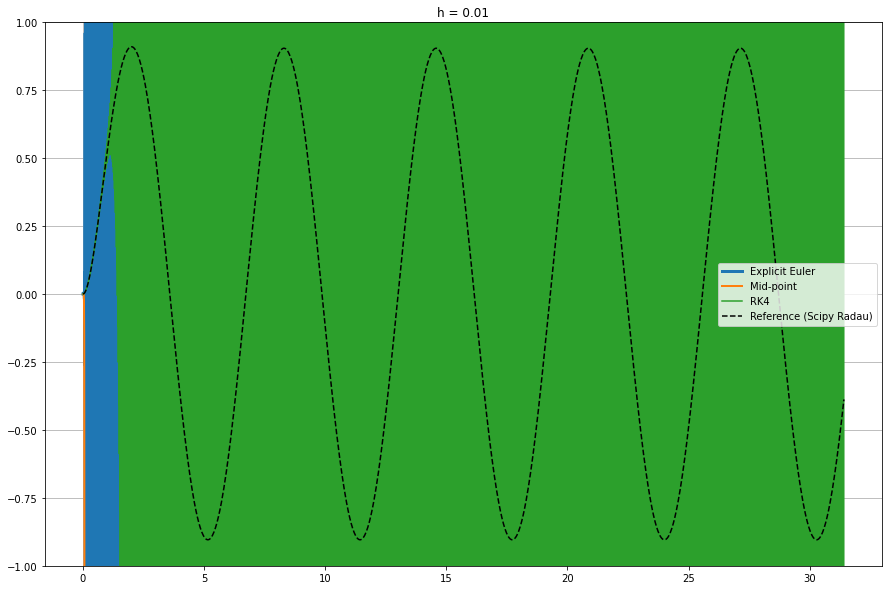

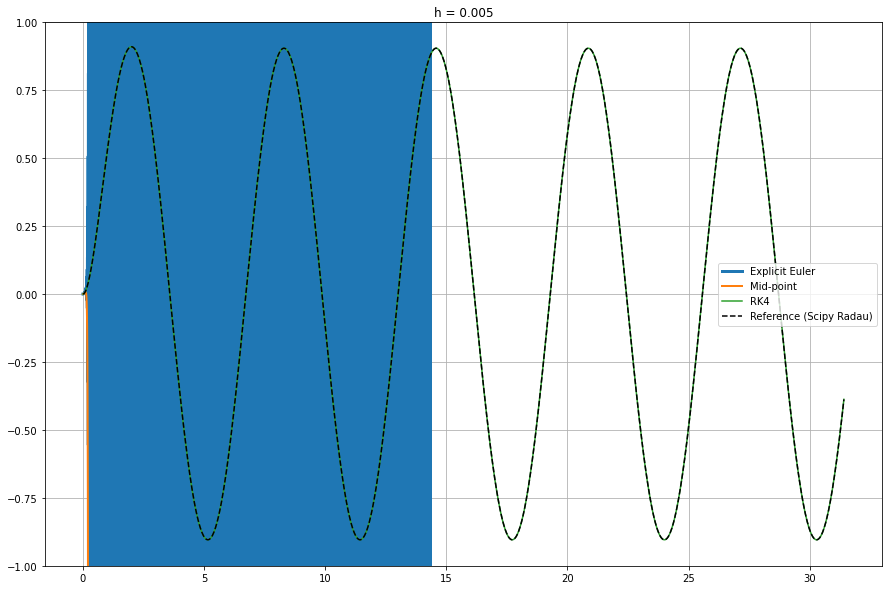

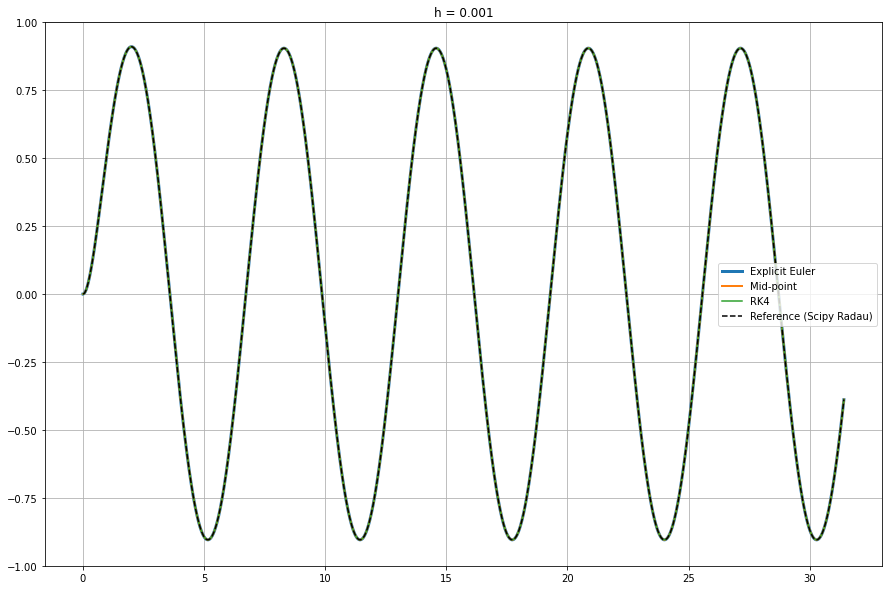

In [227]:
for h in [0.005, 0.000.001]:
    y_circuit_ee, t_ee = explicit_runge_kutta(rhs_rc_circuit, [0, 0], [0, 5*2*np.pi], a_ee, b_ee, c_ee, h, (1, 1, 0.47, 2.2e-3))
    y_circuit_rk4, t_rk4 = explicit_runge_kutta(rhs_rc_circuit, [0, 0], [0, 5*2*np.pi], a_rk4, b_rk4, c_rk4, h, (1, 1, 0.47, 2.2e-3))
    y_circuit_mp, t_mp = explicit_runge_kutta(rhs_rc_circuit, [0, 0], [0, 5*2*np.pi], a_mp, b_mp, c_mp, h, (1, 1, 0.47, 2.2e-3))
    
    plt.figure(figsize=(15, 10))
    plt.plot(t_ee, y_circuit_ee[:, 1], linewidth=3)
    plt.plot(t_mp, y_circuit_mp[:, 1], linewidth=2)
    plt.plot(t_rk4, y_circuit_rk4[:, 1])
    plt.ylim([-7, 7])
    plt.plot(t, z.T[:, 1], "--k")
    plt.ylim([-1, 1])
    plt.grid()
    plt.legend(["Explicit Euler", "Mid-point", "RK4", "Reference (Scipy Radau)"])
    plt.title("h = " + str(h))

In [210]:
# Pendulum
#
y_pendulum_ee, t_ee = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_ee, b_ee, c_ee, 0.01, (1, 1, 100, 100, 1, 1))
y_pendulum_rk4, t_rk4 = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_rk4, b_rk4, c_rk4, 0.01, (1, 1, 100, 100, 1, 1))
y_pendulum_mp, t_mp = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_mp, b_mp, c_mp, 0.01, (1, 1, 100, 100, 1, 1))

In [211]:
sol = solve_ivp(rhs_double_pendulum, [0, 7], [1, 0, 2, 0, 0, 0, 0, 0], dense_output=True, 
                args=(1, 1, 100, 100, 1, 1), atol=1e-5, rtol=1e-8, method="Radau")
t = np.linspace(0, 7, 1000)
z = sol.sol(t)

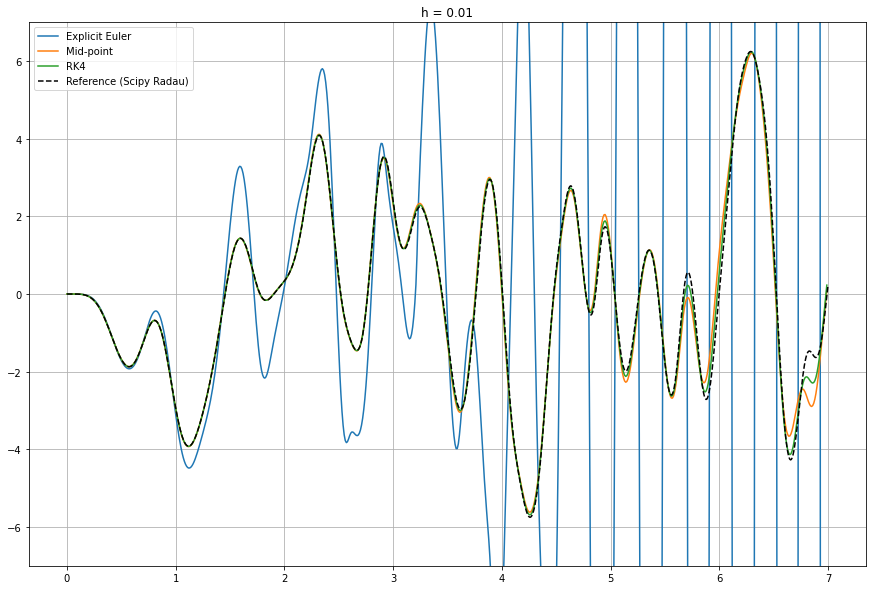

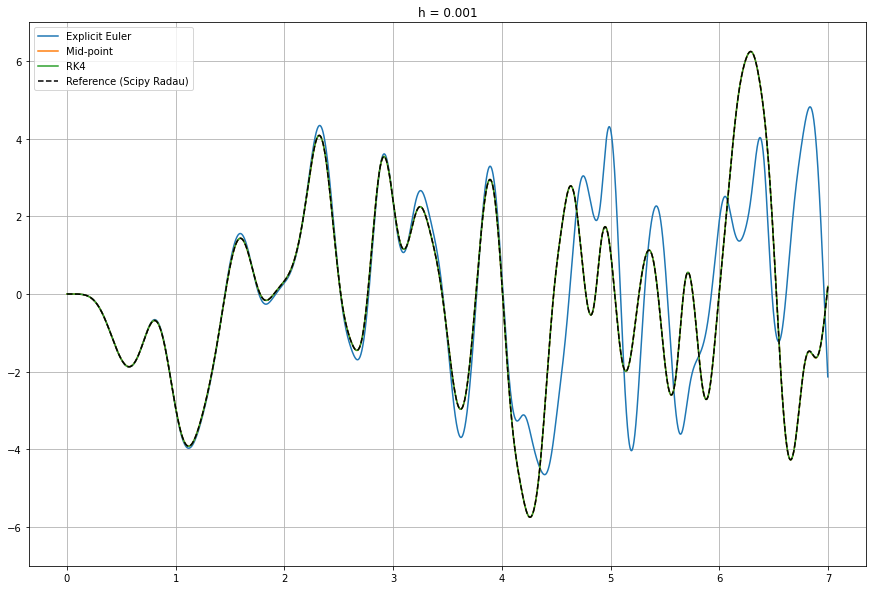

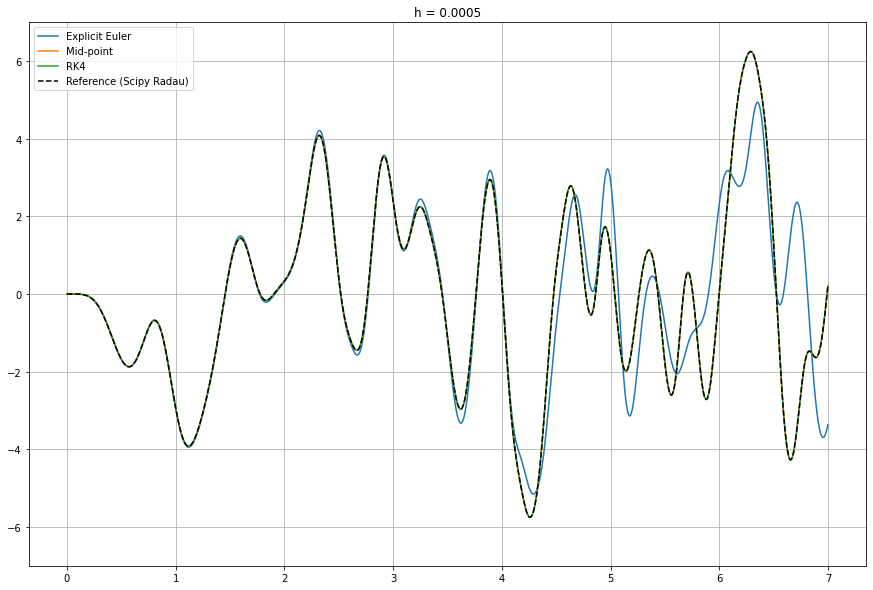

In [221]:
for h in [0.01, 0.001, 0.0005]:
    y_pendulum_ee, t_ee = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_ee, b_ee, c_ee, h, (1, 1, 100, 100, 1, 1))
    y_pendulum_rk4, t_rk4 = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_rk4, b_rk4, c_rk4, h, (1, 1, 100, 100, 1, 1))
    y_pendulum_mp, t_mp = explicit_runge_kutta(rhs_double_pendulum, [1, 0, 2, 0, 0, 0, 0, 0], [0, 7], a_mp, b_mp, c_mp, h, (1, 1, 100, 100, 1, 1))

    plt.figure(figsize=(15, 10))
    plt.plot(t_ee, y_pendulum_ee[:, 4])
    plt.plot(t_mp, y_pendulum_mp[:, 4])
    plt.plot(t_rk4, y_pendulum_rk4[:, 4])
    plt.ylim([-7, 7])
    plt.plot(t, z.T[:, 4], "--k")
    plt.grid()
    plt.legend(["Explicit Euler", "Mid-point", "RK4", "Reference (Scipy Radau)"])
    plt.title("h = " + str(h))